In [1]:
import os
import sys
import pandas as pd
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import seaborn as sns
from matplotlib.colors import LogNorm
import pickle

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"
np.random.seed(123)

In [2]:
## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
X = fitted['X']
Lt = fitted['Ltrue'].T ## k by n
F = fitted['Ftrue']
Strue = fitted['S0']
Sfit = fitted['S']
Cfit = fitted['C']
Ctrue = F @ Lt
Ctrue = (Ctrue @ Ctrue.T) / Lt.shape[1]

Pi_true = Lt.T @ F.T
# Pi = np.empty([X.shape[0], X.shape[1]])
# AB = np.empty([4, X.shape[1]])
# N = X.toarray().sum(axis = 1)
# for i in range(X.shape[1]):
#     Pi[:, i], ab, mu, var = betabinom_shrinkage(N, X.toarray()[:, i])
#     AB[:, i] = ab[0], ab[1], mu, var
    
# out = {"Pi":Pi, "AB":AB}
# file = open('improve_C2.pkl', 'wb')
# pickle.dump(out, file)
# file.close()

In [3]:
file = open('improve_C2.pkl', 'rb')
out = pickle.load(file)
file.close()

Pi = out["Pi"] ## row sums are pretty close to 1
AB = out["AB"]

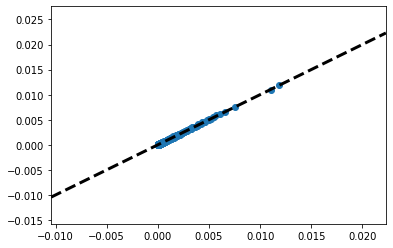

In [4]:
weights_word = X.toarray().sum(axis = 0) / X.toarray().sum()
weights_word_est = Pi.mean(axis = 0)
plt.scatter(weights_word, weights_word_est)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

## Form C and recoverS

In [5]:
n, p = Pi.shape
Chat = (Pi.T @ Pi)/n
Chat_bar = Chat / Chat.sum(axis = 1)[:, None]

## construct C from Pi true
## ad hoc when filling in diagonal elements
Chat0 = (Pi_true.T @ Pi_true)/n
Chat0_bar = Chat0 / Chat0.sum(axis = 1)[:, None]

S0, _,  _ = findS(Chat0_bar, k)
print(S0)

S, _,  _ = findS(Chat_bar, k)
print(S)

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 4.4953 seconds

[4873 7920 1956 2163 4265 7436]
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 3.1522 seconds

[4282 7914  499  832 4519 6292]


In [24]:
Chat.shape

(8766, 8766)

In [6]:
Chat_pca = Cbar_proj(Chat)
Chat0_pca = Cbar_proj(Chat0)

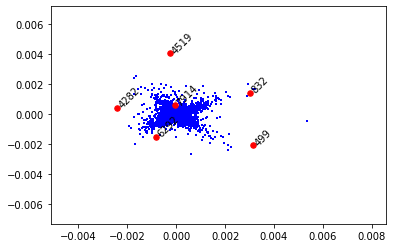

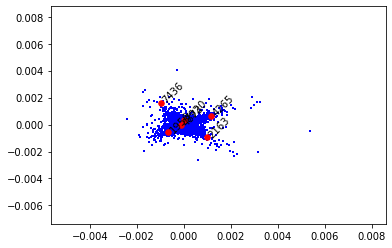

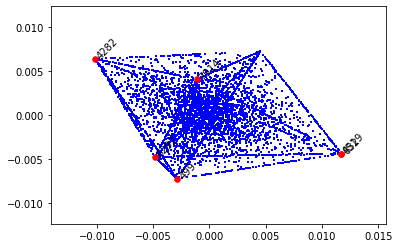

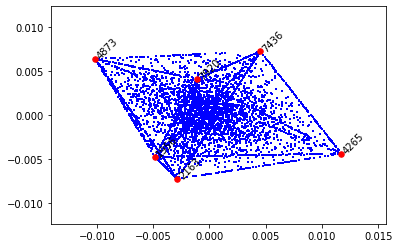

In [28]:
which_dim = [3,4]
vis_extremal_pca(Chat_pca, S, which_dim, True, 10)
vis_extremal_pca(Chat_pca, S0, which_dim, True, 10)
vis_extremal_pca(Chat0_pca, S, which_dim, True, 10)
vis_extremal_pca(Chat0_pca, S0, which_dim, True, 10)




In [22]:
print(AB[2:4, S].round(8))
print(AB[2:4, S0].round(8))

[[1.8700e-06 3.4832e-03 1.6800e-06 4.5300e-06 1.6000e-06 3.9300e-06]
 [1.0000e-08 5.2660e-05 1.0000e-08 2.0000e-08 1.0000e-08 3.0000e-08]]
[[2.83410e-04 2.12422e-03 5.27720e-04 5.25490e-04 6.39440e-04 1.17009e-03]
 [8.00000e-08 1.81200e-05 7.20000e-07 1.07000e-06 1.07000e-06 4.79000e-06]]


* The geometry is so different that PCA may not be a good visual assessment (one example is at PC 2 & 3, we have 2 recovered anchor words that are very close to each other; this shouldn't be the case in high dimension)

* But I don't really understand how we can still get most anchor words right